# Gaia Catalog of Nearby Stars
Look at the very handy dataset for stars within ~100pc

Using the actual SN 1987A space,time coordinates, which nearby stars have seen the event? Which could have "responded"?

How do the uncertainties in LMC & Gaia distances propgate into time uncertainties for when stars should see the SNe?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [4]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [5]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [6]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [7]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 35.27682304 yr>

In [8]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.638411520034424 lyr


In [9]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [10]:
print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
192489 138823 25817 134
0.580990124112619
0.4190098758873811
0.07792352827546241


In [11]:
25692 / 331312

0.07754624040179649

are any cluster members from GCNS near the Ellipsoid?

In [12]:
hc = pd.read_table('hyacomb.dat', names=('gID', 'cl', 'MC', 'd_pc'), delim_whitespace=True)
hc.shape

(1132, 4)

In [13]:
# GCNS
df = GCNS.to_pandas()
df.shape

(331312, 74)

In [14]:
cstars = df.merge(hc, left_on='SOURCE_ID', right_on='gID')
cstars.shape

(1132, 78)

In [15]:
c1.shape
# convert appropriately to do the entire ellipsoid calculation again...

(331312,)

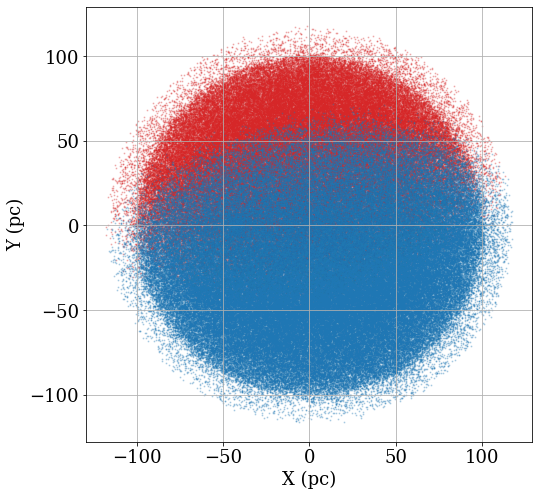

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['XCOORD_50'][SNNO], GCNS['YCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['XCOORD_50'][SNYES],GCNS['YCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A_seenXY.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

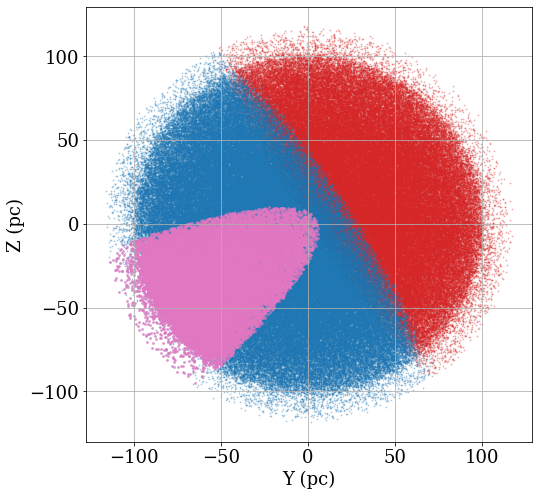

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

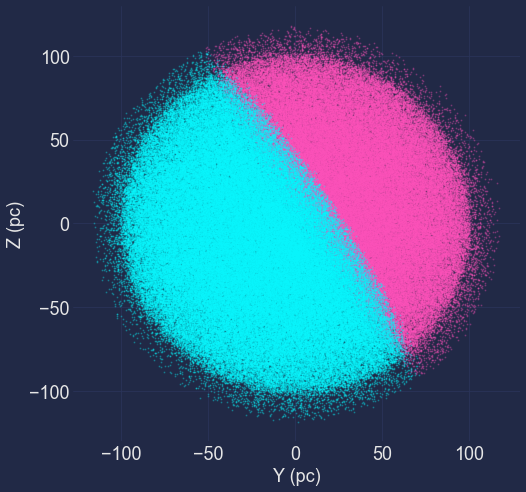

In [26]:
# # for AoT slides
# import mplcyberpunk

# plt.style.use("cyberpunk")

# plt.figure(figsize=(8,8))
# plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C1', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# # plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# # plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

# plt.xlabel('Y (pc)')
# plt.ylabel('Z (pc)')
# # plt.grid(True)
# plt.savefig('GCNS_SN1987A_AoT.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

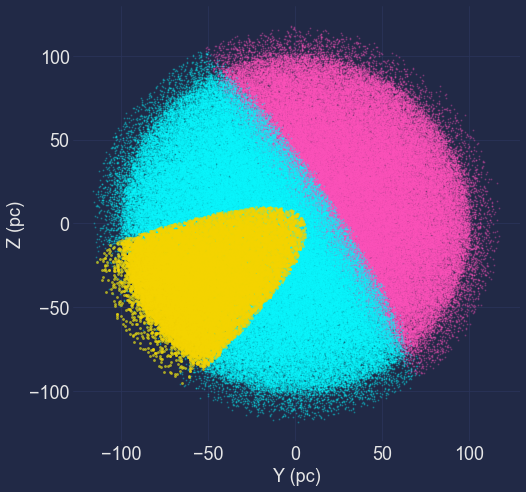

In [29]:
# # for AoT slides
# import mplcyberpunk

# plt.style.use("cyberpunk")

# plt.figure(figsize=(8,8))
# plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C1', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C2', s=4, alpha=0.5, rasterized=True)
# # plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

# plt.xlabel('Y (pc)')
# plt.ylabel('Z (pc)')
# # plt.grid(True)
# plt.savefig('GCNS_SN1987A_AoT2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

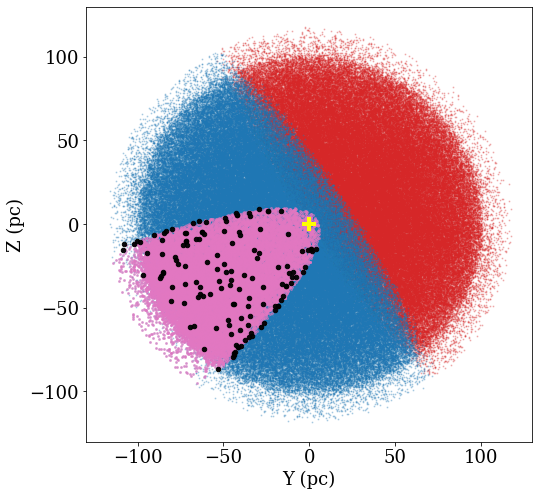

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.scatter([0],[0], c='yellow', marker='+', s=180, lw=4)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
# plt.grid(True)
plt.xlim(-130,130)
plt.ylim(-130,130)
plt.savefig('GCNS_SN1987A_on.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [19]:
GCNS.columns

<TableColumns names=('SOURCE_ID','RA','RA_ERROR','DEC','DEC_ERROR','PARALLAX','PARALLAX_ERROR','PMRA','PMRA_ERROR','PMDEC','PMDEC_ERROR','PHOT_G_MEAN_MAG','PHOT_G_MEAN_FLUX_OVER_ERROR','PHOT_BP_MEAN_MAG','PHOT_BP_MEAN_FLUX_OVER_ERROR','PHOT_RP_MEAN_MAG','PHOT_RP_MEAN_FLUX_OVER_ERROR','PHOT_BP_RP_EXCESS_FACTOR','RUWE','IPD_FRAC_MULTI_PEAK','ADOPTEDRV','ADOPTEDRV_ERROR','ADOPTEDRV_REFNAME','RADIAL_VELOCITY_IS_VALID','GCNS_PROB','WD_PROB','DIST_1','DIST_16','DIST_50','DIST_84','XCOORD_50','XCOORD_16','XCOORD_84','YCOORD_50','YCOORD_16','YCOORD_84','ZCOORD_50','ZCOORD_16','ZCOORD_84','UVEL_50','UVEL_16','UVEL_84','VVEL_50','VVEL_16','VVEL_84','WVEL_50','WVEL_16','WVEL_84','NAME_GUNN','REFNAME_GUNN','GMAG_GUNN','E_GMAG_GUNN','RMAG_GUNN','E_RMAG_GUNN','IMAG_GUNN','E_IMAG_GUNN','ZMAG_GUNN','E_ZMAG_GUNN','NAME_2MASS','J_M_2MASS','J_MSIG_2MASS','H_M_2MASS','H_MSIG_2MASS','K_M_2MASS','K_MSIG_2MASS','NAME_WISE','W1MPRO_PM_WISE','W1SIGMPRO_PM_WISE','W2MPRO_PM_WISE','W2SIGMPRO_PM_WISE','W3MPRO_WISE

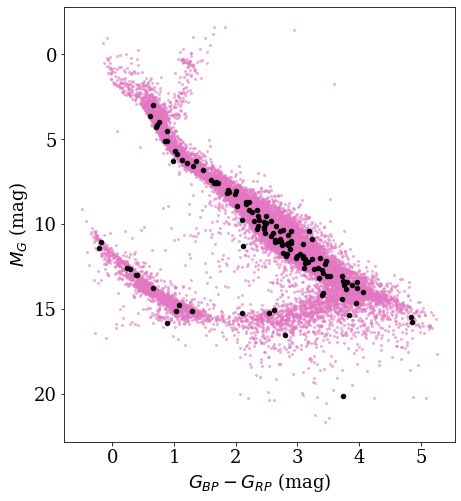

In [23]:
plt.figure(figsize=(7,8))

# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNNO] - GCNS['PHOT_RP_MEAN_MAG'][SNNO],
#             GCNS['PHOT_G_MEAN_MAG'][SNNO] - 5.*np.log10(GCNS['DIST_50'][SNNO]*1000)+5, 
#             c='C3', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNYES] - GCNS['PHOT_RP_MEAN_MAG'][SNYES],
#             GCNS['PHOT_G_MEAN_MAG'][SNYES] - 5.*np.log10(GCNS['DIST_50'][SNYES]*1000)+5, 
#             c='C0', s=1, alpha=0.25, rasterized=True)

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][EYES] - GCNS['PHOT_RP_MEAN_MAG'][EYES],
            GCNS['PHOT_G_MEAN_MAG'][EYES] - 5.*np.log10(GCNS['DIST_50'][EYES]*1000)+5, 
            c='C6', s=4, alpha=0.5, rasterized=True)

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
            GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5, 
            c='k', s=20, alpha=0.95, rasterized=True)

# yerr = 
# xerr = GCNS['']

# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.gca().invert_yaxis()

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.xlim(-130,130)
# plt.ylim(-130,130)
plt.savefig('GCNS_SN1987A_CMD_on.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
print(len(OYES))

In [ ]:
# functions for drawing ellipses and circles to scale, BUT NOT ROTATED
# b/c I'm lazy...
def echoxy0(t, c, Ntheta=1000, foci=False):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
#         foci_length = np.sqrt(np.abs(a**2 - b**2))
        fx = np.array([-c, c]) - c
        fy = np.array([0.,0.])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin

        x = a * np.cos(theta) - c
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr
    
    
def circxy0(t, c, x0=None,y0=None, Ntheta=1000):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''
    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    da = np.abs(a - c)
    acirc = a + da + c

    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    
    x = acirc * np.cos(theta) - 2*c 
    y = acirc * np.sin(theta)        

    return x * u.lyr, y * u.lyr

def circxy(t, c, x0, y0, Ntheta=1000):
    r = 2*c + t
    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    x = r * np.cos(theta) + x0
    y = r * np.sin(theta) + y0
    return x * u.lyr, y * u.lyr




In [ ]:
t=dt.to('year').value
fx0,fy0 = echoxy0(t, c.value, foci=True)
fx,fy = echoxy0(t, c.value, Ntheta=10000)
cx,cy = circxy0(t, c.value, Ntheta=10000)

plt.figure(figsize=(6,6))
plt.plot(cx.to('kpc'), cy.to('kpc'), c='C2', ls='--', lw=3, zorder=0)
plt.scatter(fx0.to('kpc'), fy0.to('kpc'), c='k')
plt.plot(fx.to('kpc'), fy.to('kpc'), c='k')
plt.xlabel(r"$x'$ (kpc)")
plt.ylabel(r"$y'$ (kpc)")
plt.text(-68, 5, 'SN 1987A')
plt.text(-20, -10, 'Earth')
plt.savefig('SN1987A_toscale.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
fx0

In [ ]:
# https://astronomy.swin.edu.au/cosmos/e/Ellipse

a = 0.5 * (t + np.sqrt(t**2 + 4 * (c.value**2)))
b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c.value**2)))
e = np.sqrt(1 - (b**2 / a**2))

print(a,b, e)

theta = np.linspace(0, 2*np.pi, 1000)
f = np.pi - theta
r = a * (1-e**2) / (1+ e*np.cos(f))
xx = c.value + r * np.cos(f)
yy = r * np.sin(f)
plt.plot(xx-c.value,yy)
plt.plot(fx.value, fy)



In [ ]:
t

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25)
plt.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25)

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.scatter((fx0).to('pc'), fy0.to('pc'), c='k')
plt.plot((fx).to('pc'), fy.to('pc'), c='k')
# plt.plot((cx).to('pc'), cy.to('pc'), c='C1')

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
Cnew = np.sqrt(xyz87.x**2 + xyz87.y**2 + xyz87.z**2).to('lyr')
cx2,cy2 = circxy(t, Cnew.value/2, Ntheta=10000, x0=xyz87.y.to('lyr').value, y0=xyz87.z.to('lyr').value)
plt.plot((cx2).to('pc'), cy2.to('pc'), c='C1')


plt.xlim(-150,150)
plt.ylim(-150,150)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)


In [ ]:
cx,cy = circxy0(t, c.value, Ntheta=10000)
# cx2,cy2 = circxy(t, c.value, Ntheta=10000, x0=xyz87.y.to('lyr').value, y0=xyz87.z.to('lyr').value)


# plt.figure(figsize=(6,6))
plt.plot((cx).to('pc'), cy.to('pc'), c='C1')
plt.plot((cx2).to('pc'), cy2.to('pc'), c='C3')
plt.grid(True)
plt.xlim(-150,450)
plt.ylim(-150,450)



In [ ]:
# what is the magic angle...?
c0.transform_to(coord.Galactic)


In [ ]:
(90 - 279.70342713)+180

In [ ]:
xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')
# ang = np.deg2rad(-32.75) # future me to past me: where did this magic angle come from?
ang = np.deg2rad( -31.9370658)

new_xpos = xpos * np.cos(ang)+ypos*np.sin(ang)
new_ypos = -xpos * np.sin(ang)+ypos*np.cos(ang)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.plot(xpos, ypos)
plt.plot(new_xpos, new_ypos)
plt.xlim(-100,100)
plt.ylim(-100,100)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25)
plt.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25)

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

# plt.scatter((fx0).to('pc'), fy0.to('pc'), c='k')
# plt.plot((fx).to('pc'), fy.to('pc'), c='k')
# plt.plot((cx).to('pc'), cy.to('pc'), c='k')
plt.xlim(-150,150)
plt.ylim(-150,150)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)

plt.plot((cx2).to('pc'), cy2.to('pc'), c='C1')
plt.plot(new_xpos, new_ypos, c='k')

In [ ]:
xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
c1987_yz = np.sqrt(xyz87.y.to('lyr').value**2 + xyz87.z.to('lyr').value**2)
ang1987_yz = np.arcsin(xyz87.z.to('lyr').value/c1987_yz)
# print(ang1987_yz)

fx0,fy0 = echoxy0(t, c1987_yz/2, foci=True)
fx,fy = echoxy0(t, c1987_yz/2 , Ntheta=10000)

xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')

new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z


xpos0, ypos0 = xpos, ypos
new_xpos0, new_ypos0 = new_xpos, new_ypos

In [ ]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=100
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.1, c='C0')

    ddist = np.abs((GCNS['DIST_16'] - GCNS['DIST_84'])/2) * np.random.normal(size=len(GCNS['DIST_50']))
    c1 = SkyCoord(ra = (GCNS['RA']) * u.degree,
              dec = (GCNS['DEC']) * u.degree,
              frame='icrs')
    # directional offset drops distance... so i dont add it until next
    c2 = c1.directional_offset_by(np.random.uniform(high=360,size=len(GCNS['RA']))*u.deg, 
                                  np.sqrt(GCNS['RA_ERROR']**2 + GCNS['DEC_ERROR']**2)*u.deg)
    c3 = SkyCoord(ra=c2.ra, dec=c2.dec,
                  distance= (GCNS['DIST_50'] + ddist) * u.kpc,
                  frame='icrs')
    xyz = c3.transform_to(coord.Galactocentric(z_sun=0, galcen_distance=8*u.kpc))
    plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
                s=20, alpha=0.3, c='r', marker='.')

plt.plot(new_xpos0, new_ypos0, c='k')
plt.grid(True)
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-55,15) # center near us
plt.ylim(-55,15)
plt.savefig('dist_err1.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [ ]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=1000
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.02, c='C0')
    
plt.plot(new_xpos0, new_ypos0, c='k')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-44500,-41500) # center near LMC
plt.ylim(-28000,-25000)
plt.xticks([-44000, -43000,-42000, -41000])
plt.yticks([-28000,-27000,-26000,-25000])
plt.grid(True)

plt.savefig('dist_err2.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [ ]:
# OTHER THINGS TO DO:
# in another notebook, explore & define the projection angle
# here, do cluster check
# here, project number of stars crossing the ellipsoid per year